# Lab 1: Базові алгоритми класифікації з використанням бібліотеки Scikit-learn

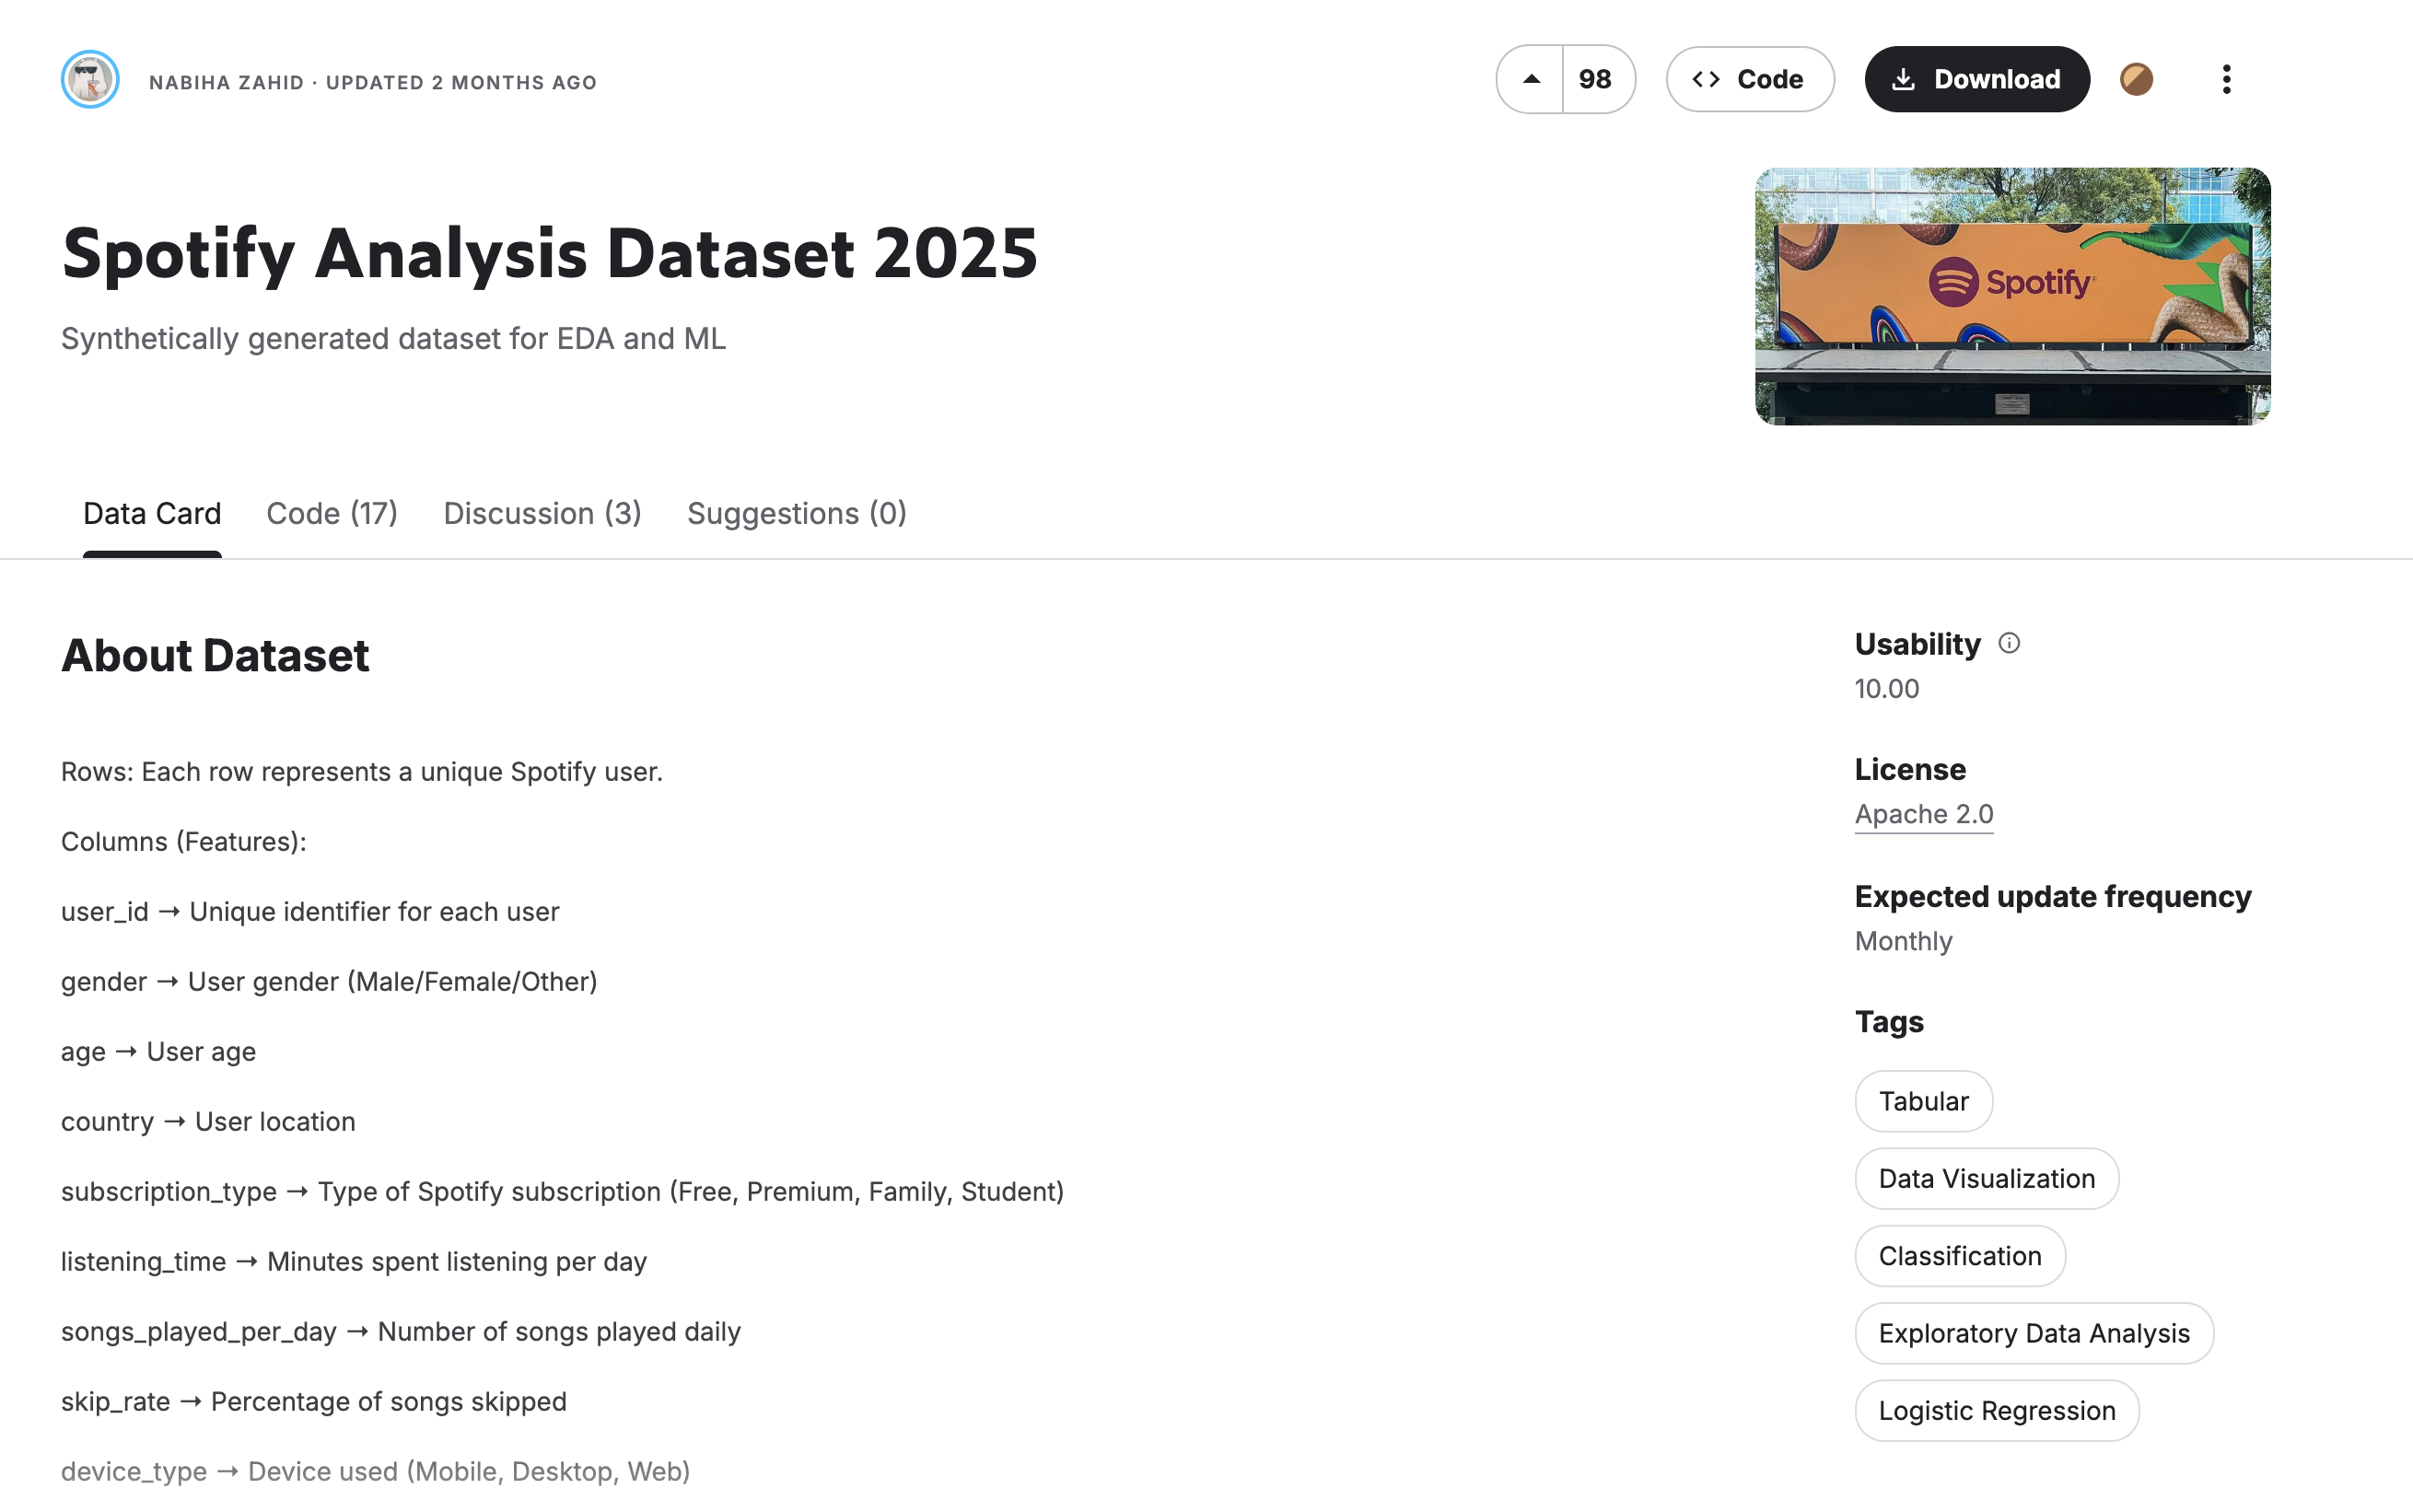
### 1) Завантажити дані, вивести назви колонок і розмір датасета

In [178]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [180]:
df = pd.read_csv('spotify_churn_dataset.csv')

print('Розмір датасету: ', df.shape[0], ' записів та ', df.shape[1], ' параметрів')
print('Назви колонок ( параметрів ): ', ", ".join(df.columns))

print('\nПерші 5 записів:')
df.head()

Розмір датасету:  8000  записів та  12  параметрів
Назви колонок ( параметрів ):  user_id, gender, age, country, subscription_type, listening_time, songs_played_per_day, skip_rate, device_type, ads_listened_per_week, offline_listening, is_churned

Перші 5 записів:


user_id  gender  age country subscription_type  listening_time  \
0        1  Female   54      CA              Free              26   
1        2   Other   33      DE            Family             141   
2        3    Male   38      AU           Premium             199   
3        4  Female   22      CA           Student              36   
4        5   Other   29      US            Family             250   

   songs_played_per_day  skip_rate device_type  ads_listened_per_week  \
0                    23       0.20     Desktop                     31   
1                    62       0.34         Web                      0   
2                    38       0.04      Mobile                      0   
3                     2       0.31      Mobile                      0   
4                    57       0.36      Mobile                      0   

   offline_listening  is_churned  
0                  0           1  
1                  1           0  
2                  1           1  
3                  1           0  
4                  1           1

### 2) Опрацювати пропуски (по можливості заповнити їх або видалити)

In [183]:
print("Пропуски по колонках: ")
print(df.isnull().sum())

# Обробка пропусків:
# - числові колонки → заповнюємо середнім
# - категоріальні → заповнюємо модою
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

print("\nПропуски після обробки: ") 
print(df.isnull().sum())

Пропуски по колонках: 
user_id                  0
gender                   0
age                      0
country                  0
subscription_type        0
listening_time           0
songs_played_per_day     0
skip_rate                0
device_type              0
ads_listened_per_week    0
offline_listening        0
is_churned               0
dtype: int64

Пропуски після обробки: 
user_id                  0
gender                   0
age                      0
country                  0
subscription_type        0
listening_time           0
songs_played_per_day     0
skip_rate                0
device_type              0
ads_listened_per_week    0
offline_listening        0
is_churned               0
dtype: int64


### 3) Візуалізувати дані: 
Побудувати гістограми розподілу ознак 

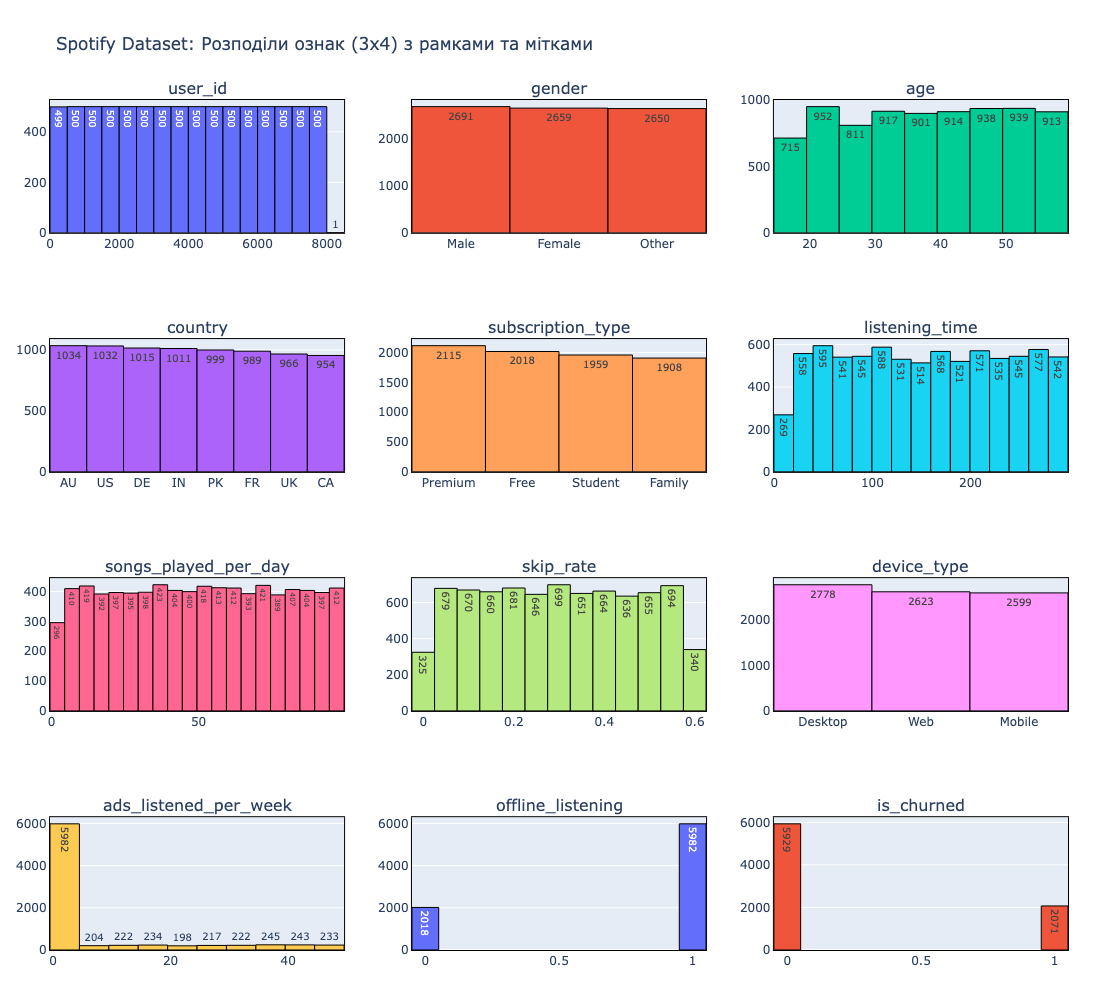

In [185]:
# Всі колонки
cols = ['user_id', 'gender', 'age', 'country', 'subscription_type',
        'listening_time', 'songs_played_per_day', 'skip_rate', 'device_type',
        'ads_listened_per_week', 'offline_listening', 'is_churned']

# Визначаємо сітку 3 на 4
fig = make_subplots(rows=4, cols=3, subplot_titles=cols)

row = 1
col = 1

for c in cols:
    if df[c].dtype in ['int64', 'float64']:
        # числові → histogram з рамкою і мітками
        fig.add_trace(go.Histogram(
            x=df[c], nbinsx=20, name=c,
            marker=dict(line=dict(color='black', width=1)),
            texttemplate='%{y}', # textposition='outside',  # мітки зверху
            textfont=dict(size=10)
        ), row=row, col=col)
    else:
        # категоріальні → bar chart з рамкою і мітками
        counts = df[c].value_counts()
        fig.add_trace(go.Bar(
            x=counts.index, y=counts.values, name=c,
            marker=dict(line=dict(color='black', width=1)),
            text=counts.values, # textposition='inside',  # мітки зверху
            textfont=dict(size=10)
        ), row=row, col=col)
    
    # Стиль осей для читабельності
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, row=row, col=col)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, row=row, col=col)
    
    col += 1
    if col > 3:
        col = 1
        row += 1

fig.update_layout(
    height=1000, width=1100,
    title_text="Spotify Dataset: Розподіли ознак (3x4) з рамками та мітками",
    showlegend=False,
    margin=dict(t=100, b=50, l=50, r=50)
)

fig.show()

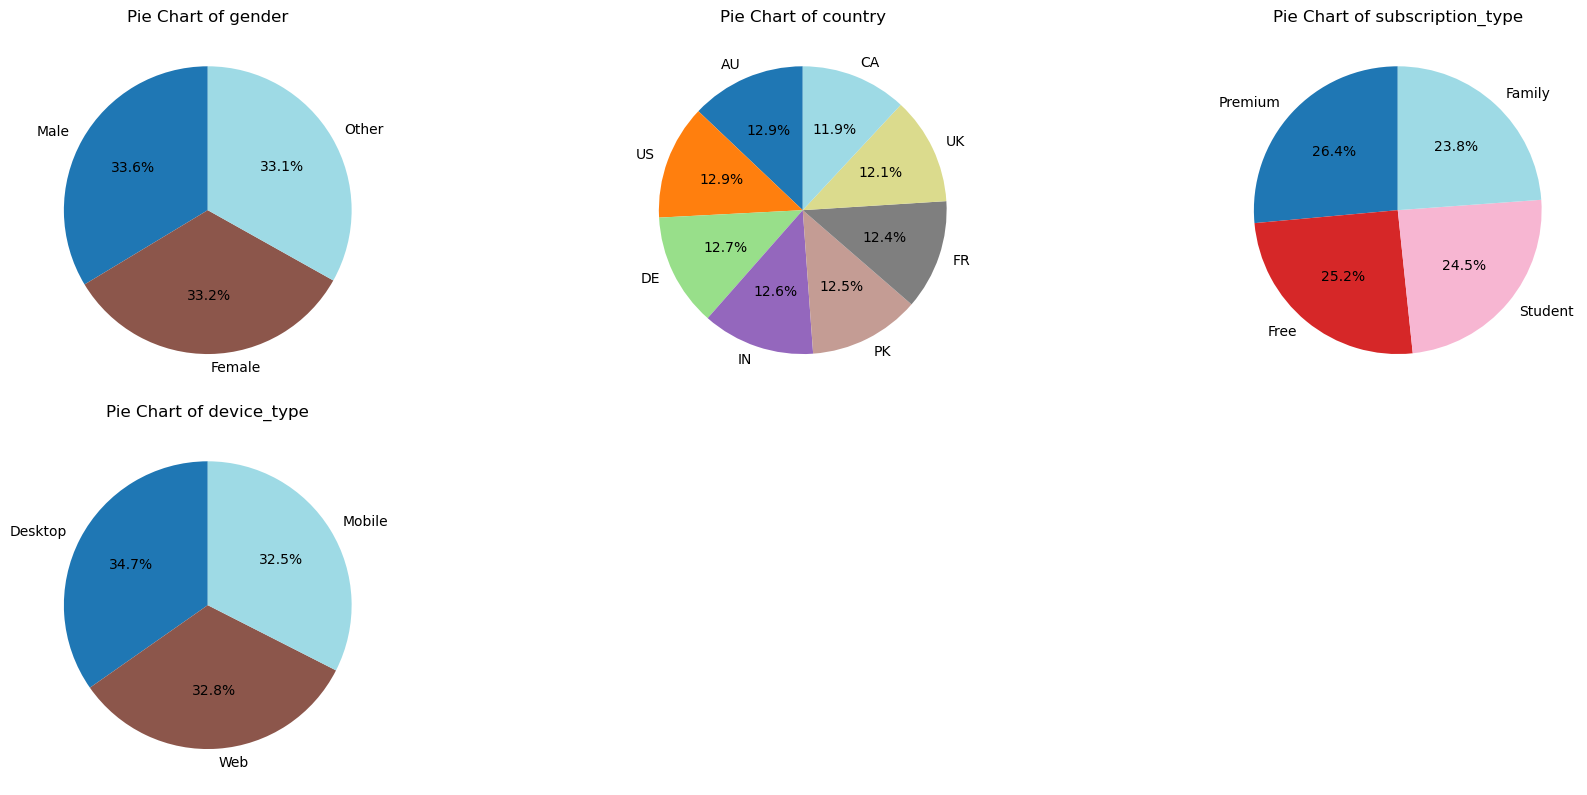

In [187]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

plt.figure(figsize=(18, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    df[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='tab20')
    plt.title(f'Pie Chart of {col}')
    plt.ylabel('') 
plt.tight_layout()
plt.show()

Побудувати графік (heatmap), що відображає кореляції ознак між собою і з цільовою змінною (розміткою)

In [189]:
# Категоріальні та числові колонки
categorical_cols = ['gender', 'country', 'subscription_type', 'device_type']
numeric_cols = ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 
                'ads_listened_per_week', 'offline_listening']
target_col = 'is_churned'

# Датасет для кореляції (без user_id)
df_corr = df[numeric_cols + categorical_cols + [target_col]].copy()

# One-hot encoding для категоріальних колонок
df_corr = pd.get_dummies(df_corr, columns=categorical_cols, drop_first=True)

# Кореляційна матриця
corr_matrix = df_corr.corr()

# Створення heatmap з підписами всередині клітинок
heatmap = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='RdBu',
    zmin=-1,
    zmax=1,
    colorbar=dict(title="Correlation"),
    text=corr_matrix.round(2).values,        # додаємо значення
    texttemplate="%{text}",                   # шаблон для відображення
    textfont={"size":10, "color":"black"}    # стиль шрифту
))

heatmap.update_layout(
    title="Spotify Dataset: Кореляції ознак (числові + категоріальні) з підписами",
    xaxis=dict(tickangle=-45),
    width=1200,
    height=1000
)

heatmap.show()

boxplot-и ознак відносно цільової змінної (якщо ознак занадто багато обмежитися декількома)

In [191]:
# Вибираємо ознаки (без user_id)
cols = ['gender', 'age', 'country', 'subscription_type',
        'listening_time', 'songs_played_per_day', 'skip_rate', 'device_type',
        'ads_listened_per_week', 'offline_listening']

target_col = 'is_churned'

# Створюємо сітку 4 на 3
fig = make_subplots(rows=4, cols=3, subplot_titles=cols)

row = 1
col = 1

for c in cols:
    if df[c].dtype in ['int64', 'float64']:
        # числові → boxplot по churn
        for val in df[target_col].unique():
            fig.add_trace(go.Box(
                y=df[df[target_col]==val][c],
                name=f"{c} (Churn={val})",
                marker=dict(line=dict(color='black', width=1))
            ), row=row, col=col)
    else:
        # категоріальні → boxplot (категорія перетворена на числову позицію)
        counts = df[c].value_counts()
        for val in df[target_col].unique():
            fig.add_trace(go.Box(
                y=df[df[target_col]==val][c].map(lambda x: counts.index.get_loc(x)),
                name=f"{c} (Churn={val})",
                marker=dict(line=dict(color='black', width=1))
            ), row=row, col=col)
    
    col += 1
    if col > 3:
        col = 1
        row += 1

fig.update_layout(
    height=1200, width=1200,
    title_text="Spotify Dataset: Boxplot-и ознак відносно churn (4x3)",
    showlegend=False,
    margin=dict(t=100, b=50, l=50, r=50)
)

fig.show()

### 4) Нормалізувати дані

In [195]:
# видаляємо параметр, який слугує ідентифікатором
df.drop("user_id", axis=1, inplace=True)

num_features = ["age", "listening_time", "songs_played_per_day", "ads_listened_per_week"]
print("Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df[num_features].describe().T.style.background_gradient(cmap=cm))

Data describe:


In [196]:
# перевірка на дублікати
def check_duplicates_report(df, dataset_name):
    duplicates_count = df.duplicated().sum()
    total_rows = len(df)
    
    print(f"🔍 {dataset_name} Аналіз дублікатів")
    
    if duplicates_count == 0:
        print(f"✅ Дублікатів не знайдемо серед {total_rows:,} записів")
    else:
        print(f"⚠️  {duplicates_count} duplicates found ({duplicates_count/total_rows:.2%})")
        print(f"    Total rows affected: {duplicates_count:,}/{total_rows:,}")

datasets = {
    "Data": df
}

duplicate_summary = {}
for name, data in datasets.items():
    check_duplicates_report(data, name)
    duplicate_summary[name] = {
        "duplicates": data.duplicated().sum(),
        "total_rows": len(data)
    }

🔍 Data Аналіз дублікатів
✅ Дублікатів не знайдемо серед 8,000 записів


In [201]:
# 1. One-Hot Encoding для gender, subscription_type, device_type
one_hot_cols = ['gender', 'subscription_type', 'device_type']
df_one_hot = pd.get_dummies(df[one_hot_cols], drop_first=True)

# 2. Frequency Encoding для country
freq_encoding = df['country'].value_counts(normalize=True)  # частка появи
df['country_freq'] = df['country'].map(freq_encoding)

df_encoded = pd.concat([df.drop(columns=one_hot_cols + ['country']), df_one_hot], axis=1)

# Тепер df_encoded
print("Після кодування:")
df_encoded.head()

Після кодування:


age  listening_time  songs_played_per_day  skip_rate  \
0   54              26                    23       0.20   
1   33             141                    62       0.34   
2   38             199                    38       0.04   
3   22              36                     2       0.31   
4   29             250                    57       0.36   

   ads_listened_per_week  offline_listening  is_churned  country_freq  \
0                     31                  0           1      0.119250   
1                      0                  1           0      0.126875   
2                      0                  1           1      0.129250   
3                      0                  1           0      0.119250   
4                      0                  1           1      0.129000   

   gender_Male  gender_Other  subscription_type_Free  \
0        False         False                    True   
1        False          True                   False   
2         True         False                   False   
3        False         False                   False   
4        False          True                   False   

   subscription_type_Premium  subscription_type_Student  device_type_Mobile  \
0                      False                      False               False   
1                      False                      False               False   
2                       True                      False                True   
3                      False                       True                True   
4                      False                      False                True   

   device_type_Web  
0            False  
1             True  
2            False  
3            False  
4            False

In [208]:

# Створюємо копію df_encoded, щоб не зіпсувати оригінал
df = df_encoded.copy()

# 1. Standard Scaling для age та songs_played_per_day
scaler_std = StandardScaler()
df[['age_scaled', 'songs_played_scaled']] = scaler_std.fit_transform(df[['age', 'songs_played_per_day']])
df.drop(columns=['age', 'songs_played_per_day'], inplace=True)  # видаляємо оригінальну колонку

# 2. MinMax Scaling для listening_time
scaler_mm = MinMaxScaler()
df['listening_time_scaled'] = scaler_mm.fit_transform(df[['listening_time']])
df.drop(columns=['listening_time'], inplace=True)  # видаляємо оригінальну колонку

# 3. Log + MinMax для ads_listened_per_week
df['ads_log_scaled'] = np.log1p(df['ads_listened_per_week'])
df['ads_scaled'] = scaler_mm.fit_transform(df[['ads_log_scaled']])
df.drop(columns=['ads_listened_per_week', 'ads_log_scaled'], inplace=True)

df.head()

skip_rate  offline_listening  is_churned  country_freq  gender_Male  \
0       0.20                  0           1      0.119250        False   
1       0.34                  1           0      0.126875        False   
2       0.04                  1           1      0.129250         True   
3       0.31                  1           0      0.119250        False   
4       0.36                  1           1      0.129000        False   

   gender_Other  subscription_type_Free  subscription_type_Premium  \
0         False                    True                      False   
1          True                   False                      False   
2         False                   False                       True   
3         False                   False                      False   
4          True                   False                      False   

   subscription_type_Student  device_type_Mobile  device_type_Web  age_scaled  \
0                      False               False            False    1.282452   
1                      False               False             True   -0.365956   
2                      False                True            False    0.026522   
3                       True                True            False   -1.229408   
4                      False                True            False   -0.679939   

   songs_played_scaled  listening_time_scaled  ads_scaled  
0            -0.953574               0.055363    0.885919  
1             0.417349               0.453287    0.000000  
2            -0.426296               0.653979    0.000000  
3            -1.691763               0.089965    0.000000  
4             0.241590               0.830450    0.000000

In [210]:
df.columns

Index(['skip_rate', 'offline_listening', 'is_churned', 'country_freq',
       'gender_Male', 'gender_Other', 'subscription_type_Free',
       'subscription_type_Premium', 'subscription_type_Student',
       'device_type_Mobile', 'device_type_Web', 'age_scaled',
       'songs_played_scaled', 'listening_time_scaled', 'ads_scaled'],
      dtype='object')

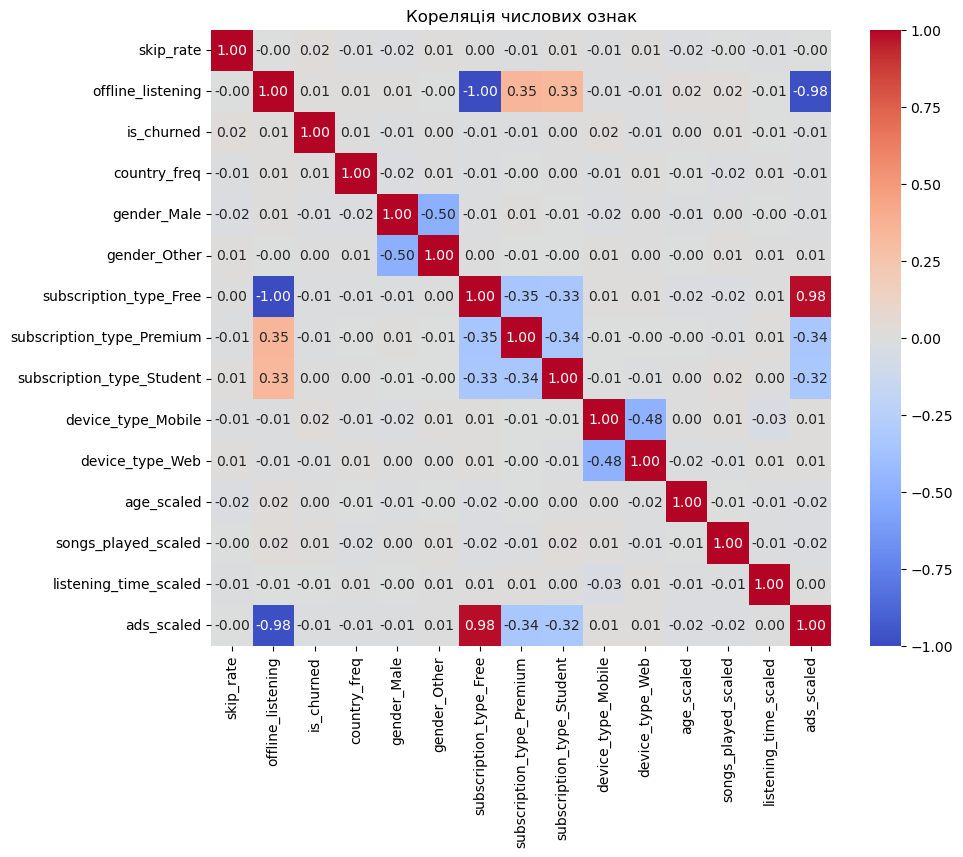

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt

# Вибираємо числові колонки для кореляційного аналізу
numeric_cols = ['age_scaled', 'songs_played_scaled', 'listening_time_scaled', 'ads_scaled', 'skip_rate', 'offline_listening', 'country_freq']

# Кореляційна матриця
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Кореляція числових ознак")
plt.show()

In [220]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Копія датасету
df_all = df.copy()

# 1. Кореляційна матриця для всіх колонок, крім цільової
corr_matrix = df_all.drop(columns=['is_churned']).corr().abs()

# 2. Верхня трикутна маска
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Визначаємо сильно корельовані колонки (>0.8)
to_drop = []
for col in upper.columns:
    high_corr = upper[col][upper[col] > 0.8]
    for row in high_corr.index:
        # Порівнюємо кореляцію з цільовою змінною
        corr_col = df_all[col].corr(df_all['is_churned'])
        corr_row = df_all[row].corr(df_all['is_churned'])
        # Видаляємо менш інформативну
        if corr_col < corr_row:
            to_drop.append(col)
        else:
            to_drop.append(row)

to_drop = list(set(to_drop))  # унікальні колонки
df_filtered = df_all.drop(columns=to_drop)

print("Видалені сильно корельовані ознаки:", to_drop)

# 4. Автоматично нормалізуємо всі числові колонки, крім цільової
num_cols_filtered = df_filtered.select_dtypes(include=[np.number]).columns.tolist()
num_cols_filtered = [col for col in num_cols_filtered if col != 'is_churned']

scaler = StandardScaler()
df_filtered[num_cols_filtered] = scaler.fit_transform(df_filtered[num_cols_filtered])

# df_filtere_

Видалені сильно корельовані ознаки: ['ads_scaled', 'subscription_type_Free']


In [222]:
df_filtered

skip_rate  offline_listening  is_churned  country_freq  gender_Male  \
0     -0.576827          -1.721720           1     -1.727792        False   
1      0.229702           0.580814           0      0.527136        False   
2     -1.498575           0.580814           1      1.229490         True   
3      0.056875           0.580814           0     -1.727792        False   
4      0.344921           0.580814           1      1.155558        False   
...         ...                ...         ...           ...          ...   
7995  -0.000735           0.580814           1      0.527136        False   
7996   1.669933           0.580814           0      1.229490         True   
7997   0.172093          -1.721720           0      1.155558        False   
7998  -0.173562           0.580814           0      0.379272        False   
7999   0.921013          -1.721720           0      1.229490        False   

      gender_Other  subscription_type_Premium  subscription_type_Student  \
0            False                      False                      False   
1             True                      False                      False   
2            False                       True                      False   
3            False                      False                       True   
4             True                      False                      False   
...            ...                        ...                        ...   
7995          True                      False                       True   
7996         False                       True                      False   
7997         False                      False                      False   
7998         False                      False                       True   
7999          True                      False                      False   

      device_type_Mobile  device_type_Web  age_scaled  songs_played_scaled  \
0                  False            False    1.282452            -0.953574   
1                  False             True   -0.365956             0.417349   
2                   True            False    0.026522            -0.426296   
3                   True            False   -1.229408            -1.691763   
4                   True            False   -0.679939             0.241590   
...                  ...              ...         ...                  ...   
7995                True            False    0.497495            -0.496599   
7996                True            False   -0.287461             0.487653   
7997               False            False   -1.621886             0.417349   
7998               False            False   -0.287461             1.542209   
7999               False            False    0.575991             0.628261   

      listening_time_scaled  
0                 -1.524434  
1                 -0.155555  
2                  0.534836  
3                 -1.405401  
4                  1.141904  
...                     ...  
7995               0.987161  
7996              -1.107819  
7997              -0.869753  
7998               1.082388  
7999               0.665772  

[8000 rows x 13 columns]

### 5) Провести навчання наступних класифікаторів:
- kNN
- дерево ухвалення рішень
- SVM
- Random Forest
- AdaBoost

Підібрати оптимальні параметри
• для kNN
• для SVM за допомогою GridSearch підібрати оптимальні «C» і «gamma»

##### Серед обраних оптимальних моделей кожного класу вибрати найкращу.
##### Відобразити sklearn.metrics.classification_report і sklearn.metrics.confusion_matrix

In [232]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

# =========================
# 1. Підготовка даних
# =========================
X = df_filtered.drop(columns=['is_churned'])
y = df_filtered['is_churned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# =========================
# 2. kNN з підбором оптимального k
# =========================
knn_params = {'n_neighbors': list(range(1, 21))}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
knn_grid.fit(X_train, y_train)
knn_best = knn_grid.best_estimator_
y_pred_knn = knn_best.predict(X_test)
print("kNN best params:", knn_grid.best_params_)
print("kNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("kNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

# =========================
# 3. Decision Tree
# =========================
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)
y_pred_tree = dtree.predict(X_test)
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree))
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tree))

# =========================
# 4. SVM з підбором C і gamma
# =========================
svm_params = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1], 'kernel': ['rbf']}
svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy')
svm_grid.fit(X_train, y_train)
svm_best = svm_grid.best_estimator_
y_pred_svm = svm_best.predict(X_test)
print("\nSVM best params:", svm_grid.best_params_)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

# =========================
# 5. Random Forest
# =========================
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# =========================
# 6. AdaBoost
# =========================
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train, y_train)
y_pred_ab = ab.predict(X_test)
print("\nAdaBoost Classification Report:")
print(classification_report(y_test, y_pred_ab))
print("AdaBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ab))

# =========================
# 7. Вибір найкращої моделі
# =========================
models_accuracy = {
    'kNN': knn_best.score(X_test, y_test),
    'Decision Tree': dtree.score(X_test, y_test),
    'SVM': svm_best.score(X_test, y_test),
    'Random Forest': rf.score(X_test, y_test),
    'AdaBoost': ab.score(X_test, y_test)
}

best_model_name = max(models_accuracy, key=models_accuracy.get)
print("\nНайкраща модель:", best_model_name, "з точністю:", models_accuracy[best_model_name])

kNN best params: {'n_neighbors': 20}
kNN Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1186
           1       0.25      0.00      0.01       414

    accuracy                           0.74      1600
   macro avg       0.50      0.50      0.43      1600
weighted avg       0.61      0.74      0.63      1600

kNN Confusion Matrix:
[[1180    6]
 [ 412    2]]

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1186
           1       0.28      0.30      0.29       414

    accuracy                           0.62      1600
   macro avg       0.51      0.51      0.51      1600
weighted avg       0.63      0.62      0.62      1600

Decision Tree Confusion Matrix:
[[861 325]
 [290 124]]

SVM best params: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
SVM Classification Report:
              precision    recall  f1-score   suppor

/Users/bohdanr/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/bohdanr/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/bohdanr/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1186
           1       0.26      0.01      0.02       414

    accuracy                           0.74      1600
   macro avg       0.50      0.50      0.44      1600
weighted avg       0.62      0.74      0.63      1600

Random Forest Confusion Matrix:
[[1172   14]
 [ 409    5]]


/Users/bohdanr/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.




AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1186
           1       0.00      0.00      0.00       414

    accuracy                           0.74      1600
   macro avg       0.37      0.50      0.43      1600
weighted avg       0.55      0.74      0.63      1600

AdaBoost Confusion Matrix:
[[1186    0]
 [ 414    0]]


/Users/bohdanr/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/bohdanr/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/bohdanr/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Найкраща модель: SVM з точністю: 0.74125


              precision    recall  f1-score   support

           0       0.75      0.57      0.65      1186
           1       0.27      0.45      0.33       414

    accuracy                           0.54      1600
   macro avg       0.51      0.51      0.49      1600
weighted avg       0.62      0.54      0.57      1600



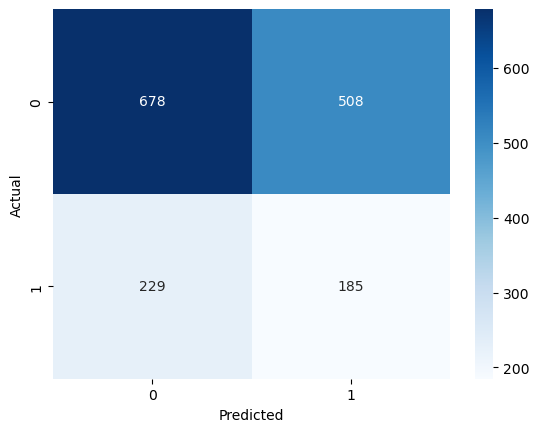

In [230]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Балансування тренувальної вибірки
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# SVM з balanced class weight
svm = SVC(C=1, gamma=0.1, kernel='rbf', class_weight='balanced')
svm.fit(X_train_bal, y_train_bal)

# Прогноз на тесті
y_pred = svm.predict(X_test)

# Метрики
print(classification_report(y_test, y_pred, zero_division=0))

# Матриця плутанини
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


=== SVM ===
              precision    recall  f1-score   support

           0       0.74      0.48      0.59      1186
           1       0.26      0.51      0.34       414

    accuracy                           0.49      1600
   macro avg       0.50      0.50      0.47      1600
weighted avg       0.62      0.49      0.52      1600



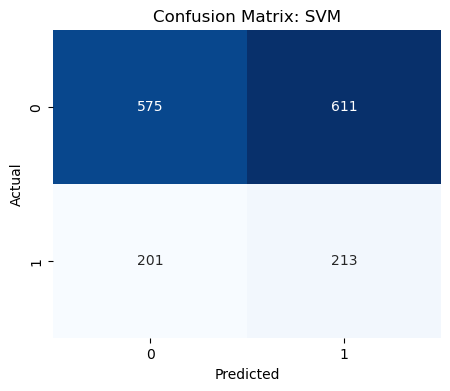


=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1186
           1       0.27      0.27      0.27       414

    accuracy                           0.62      1600
   macro avg       0.51      0.51      0.51      1600
weighted avg       0.62      0.62      0.62      1600



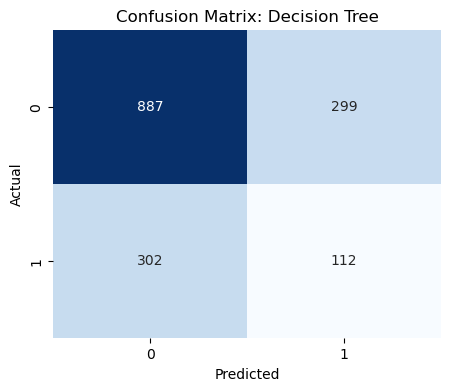


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1186
           1       0.38      0.01      0.03       414

    accuracy                           0.74      1600
   macro avg       0.56      0.50      0.44      1600
weighted avg       0.65      0.74      0.64      1600



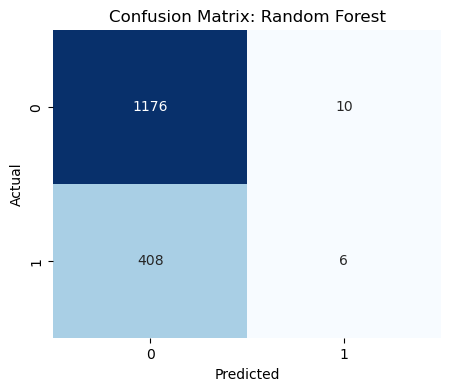

/Users/bohdanr/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.




=== AdaBoost ===
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1186
           1       0.00      0.00      0.00       414

    accuracy                           0.74      1600
   macro avg       0.37      0.50      0.43      1600
weighted avg       0.55      0.74      0.63      1600



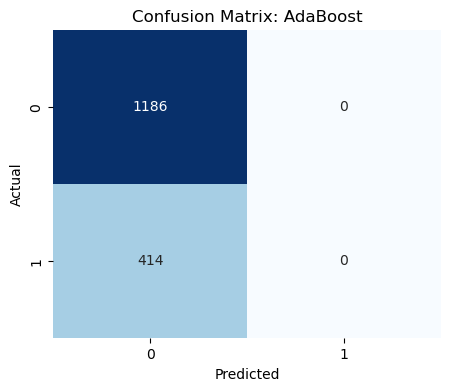


=== kNN ===
              precision    recall  f1-score   support

           0       0.75      0.89      0.81      1186
           1       0.32      0.15      0.21       414

    accuracy                           0.70      1600
   macro avg       0.54      0.52      0.51      1600
weighted avg       0.64      0.70      0.66      1600



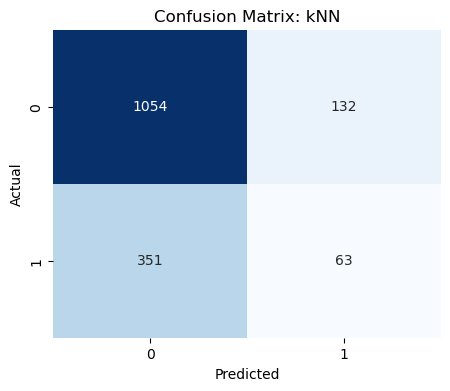


Найкраща модель: AdaBoost з точністю: 0.7412


In [234]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"\n=== {model_name} ===")
    print(classification_report(y_test, y_pred, zero_division=0))
    plot_conf_matrix(y_test, y_pred, model_name)
    return model.score(X_test, y_test)

# ======================
# Пряме використання моделей з class_weight='balanced'
# ======================
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# SVM
svm_best = SVC(C=1, gamma=0.1, kernel='rbf', class_weight='balanced')
svm_best.fit(X_train, y_train)
acc_svm = evaluate_model(svm_best, X_test, y_test, "SVM")

# Decision Tree
dtree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dtree.fit(X_train, y_train)
acc_tree = evaluate_model(dtree, X_test, y_test, "Decision Tree")

# Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
acc_rf = evaluate_model(rf, X_test, y_test, "Random Forest")

# AdaBoost (підтримує sample_weight через fit, але ми залишимо стандарт)
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train, y_train)
acc_ab = evaluate_model(ab, X_test, y_test, "AdaBoost")

# kNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
acc_knn = evaluate_model(knn, X_test, y_test, "kNN")

# Вибір найкращої моделі
accuracies = {'SVM': acc_svm, 'Decision Tree': acc_tree, 'Random Forest': acc_rf, 'AdaBoost': acc_ab, 'kNN': acc_knn}
best_model = max(accuracies, key=accuracies.get)
print(f"\nНайкраща модель: {best_model} з точністю: {accuracies[best_model]:.4f}")

### ЗАДАЧА має проблему: удані дуже незбалансовані (is_churned=1 ≈ 25%), тому більшість моделей “ігнорують” клас 1

In [238]:
# модифікована модель

LightGBM best params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 63}

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      1186
           1       0.27      0.16      0.20       414

    accuracy                           0.67      1600
   macro avg       0.51      0.50      0.50      1600
weighted avg       0.62      0.67      0.64      1600



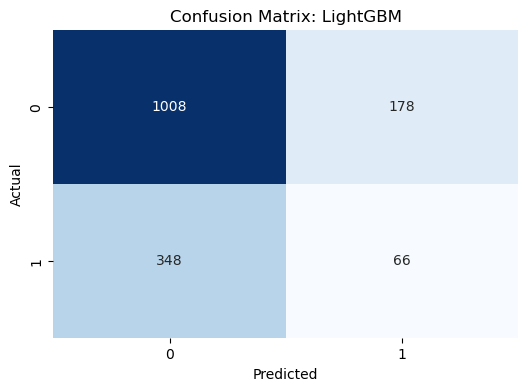

In [250]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

# =========================
# 1. Підготовка даних
# =========================
X = df_filtered.drop(columns=['is_churned'])
y = df_filtered['is_churned']

# Стратифіковане train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Балансування класів за допомогою SMOTE
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# =========================
# 2. GridSearchCV для підбору параметрів LightGBM без зайвих повідомлень
# =========================
lgbm = LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [15, 31, 63]
}

grid = GridSearchCV(lgbm, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=0)
grid.fit(X_train_bal, y_train_bal)

best_lgbm = grid.best_estimator_
print("LightGBM best params:", grid.best_params_)

# =========================
# 3. Прогноз та оцінка моделі
# =========================
y_pred = best_lgbm.predict(X_test)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix з heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix: LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()